In [1]:
#some of these maybe not needed anymore...
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.feature import greycoprops, greycomatrix, graycoprops, graycomatrix
from skimage.measure import shannon_entropy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization, Reshape, AveragePooling2D, concatenate, Input
import keras
from sklearn.preprocessing import LabelEncoder
import keras.utils as ku
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time
import warnings
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = "/content/drive/MyDrive/Skripsi Face Recognition CNN/ORL/"

imgs = [] #image matrix
labels = []

for filename in os.listdir(data_path):
    img = cv2.imread(data_path + filename,0)
    imgs.append(img)
    labels.append(os.path.splitext(filename)[0].split('_')[1])

In [3]:
dct_imgs = []

for img in imgs:
  dct = cv2.dct(np.float32(img))
  # thresh = 0.25
  # dct_lowfreq = dct * (np.abs(dct) > (thresh*np.max(dct)))
  dct_lowfreq = dct[:8, :8]
  dct_imgs.append(np.uint8(dct_lowfreq))

In [4]:
def calculate_metric(P, weights):

    results = np.apply_over_axes( #apply a function repeatedly over multiple axes.
        np.sum, (P * weights), axes=(0, 1))[0, 0]

    return results

In [5]:
graycomatrices = []
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[1], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):

    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    # Calculate ASM, contrast, correlation, homogeneity dan dissimilarity
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)

    # Calculate entropy
    feature.append(shannon_entropy(glcm[:, :, 0, 0]))
    feature.append(shannon_entropy(glcm[:, :, 0, 1]))
    feature.append(shannon_entropy(glcm[:, :, 0, 2]))
    feature.append(shannon_entropy(glcm[:, :, 0, 3]))

    (num_level, num_level2, num_dist, num_angle) = glcm.shape
    # Calculate properties related to autocorrelation
    i = np.arange(num_level).reshape((num_level, 1, 1, 1))
    j = np.arange(num_level).reshape((1, num_level, 1, 1))
    # Calculate autocorrelation
    autocorrelation = calculate_metric(glcm, i * j)
    feature.extend(autocorrelation[:,0])
    feature.extend(autocorrelation[:,1])
    feature.extend(autocorrelation[:,2])
    feature.extend(autocorrelation[:,3])

    feature.append(label)
    return feature

In [6]:
# ----------------- call calc_glcm_all_agls() for all GLCM feature ----------------------------------
glcm_feature = [ 'ASM','contrast','correlation', 'homogeneity', 'dissimilarity', 'entropy', 'autocorrelation']
properties = glcm_feature[:5]
glcm_all_agls=[]
for img, label in zip(dct_imgs,labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                               label,
                               props=properties)
                               )

In [7]:
columns = []
angles = ['0', '45', '90','135']
for name in glcm_feature :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df

ASM_0    ASM_45    ASM_90   ASM_135    contrast_0   contrast_45  \
0    0.008929  0.010204  0.008929  0.010204  12079.946429  11403.612245   
1    0.009247  0.010204  0.009247  0.010412  14887.053571  12326.571429   
2    0.009088  0.010204  0.008929  0.010204  13677.642857  14162.836735   
3    0.009407  0.010621  0.008929  0.010621   8894.875000  11156.061224   
4    0.008929  0.010204  0.009088  0.010412  12416.964286  10859.653061   
..        ...       ...       ...       ...           ...           ...   
395  0.008929  0.010204  0.009247  0.010204  10548.839286  11232.795918   
396  0.008929  0.010204  0.009088  0.010829  12056.535714  12983.102041   
397  0.008929  0.010204  0.008929  0.010204  13163.446429  11303.204082   
398  0.008929  0.010204  0.008929  0.010204  11414.053571   9498.653061   
399  0.008929  0.010204  0.009407  0.010204   9018.428571  11862.591837   

      contrast_90  contrast_135  correlation_0  correlation_45  ...  \
0    11349.714286  11763.632653       0.108199        0.127437  ...   
1    14128.571429  13527.102041      -0.235277        0.015068  ...   
2    15221.142857  15319.040816       0.022507        0.008388  ...   
3     8983.071429   8784.571429      -0.013371       -0.212215  ...   
4    12039.714286   8937.755102      -0.205393       -0.006253  ...   
..            ...           ...            ...             ...  ...   
395  12995.696429  10737.448980       0.069968       -0.038127  ...   
396  14876.142857  11859.448980       0.001170       -0.025193  ...   
397  10684.017857   9257.979592      -0.256190       -0.062680  ...   
398  12310.839286   8893.244898      -0.005435        0.135403  ...   
399   9808.321429   7663.714286       0.082965       -0.213758  ...   

     dissimilarity_135  entropy_0  entropy_45  entropy_90  entropy_135  \
0            84.571429   0.018174    0.016190    0.018174     0.016190   
1            91.632653   0.018113    0.016190    0.018113     0.016169   
2           102.183673   0.018159    0.016190    0.018174     0.016190   
3            77.387755   0.018054    0.016117    0.018174     0.016117   
4            69.428571   0.018174    0.016190    0.018159     0.016169   
..                 ...        ...         ...         ...          ...   
395          88.142857   0.018174    0.016190    0.018113     0.016190   
396          86.795918   0.018174    0.016190    0.018159     0.016053   
397          75.612245   0.018174    0.016190    0.018174     0.016190   
398          71.204082   0.018174    0.016190    0.018174     0.016190   
399          71.673469   0.018174    0.016190    0.018054     0.016190   

     autocorrelation_0  autocorrelation_45  autocorrelation_90  \
0         14240.642857        15859.000000        15468.214286   
1         13190.875000        14381.857143        13377.017857   
2         14026.732143        14155.408163        14260.321429   
3         15828.571429        15160.265306        16284.535714   
4         21084.607143        21764.673469        21448.517857   
..                 ...                 ...                 ...   
395       16865.482143        14730.061224        15064.321429   
396       14428.500000        13582.061224        13440.928571   
397       11794.553571        13129.755102        13528.535714   
398       16214.017857        17253.408163        15426.892857   
399       16993.714286        15932.448980        15928.803571   

     autocorrelation_135  label  
0           15662.897959     11  
1           13525.877551     11  
2           13525.918367     10  
3           15992.795918     11  
4           22624.163265     11  
..                   ...    ...  
395         15427.653061     10  
396         14610.285714     10  
397         14174.734694     10  
398         17083.040816     10  
399         17980.306122     10  

[400 rows x 29 columns]

In [8]:
X = glcm_df.iloc[:,:-1]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
glcm_scaled = scaler.transform(X)

In [9]:
columns = []
angles = ['0', '45', '90','135']
for name in glcm_feature :
    for ang in angles:
        columns.append(name + "_" + ang)

pd.DataFrame(glcm_scaled, columns=columns)

ASM_0    ASM_45    ASM_90   ASM_135  contrast_0  contrast_45  \
0   -0.706855 -0.560914 -0.614966 -0.574020    0.522632     0.139280   
1    1.049306 -0.560914  1.187133  0.484081    1.985617     0.593239   
2    0.171226 -0.560914 -0.614966 -0.574020    1.355306     1.496409   
3    1.927386  1.488086 -0.614966  1.542182   -1.137337     0.017521   
4   -0.706855 -0.560914  0.286083  0.484081    0.698276    -0.128268   
..        ...       ...       ...       ...         ...          ...   
395 -0.706855 -0.560914  1.187133 -0.574020   -0.275337     0.055263   
396 -0.706855 -0.560914  0.286083  2.600283    0.510431     0.916155   
397 -0.706855 -0.560914 -0.614966 -0.574020    1.087322     0.089894   
398 -0.706855 -0.560914 -0.614966 -0.574020    0.175588    -0.797678   
399 -0.706855 -0.560914  2.088182 -0.574020   -1.072944     0.365030   

     contrast_90  contrast_135  correlation_0  correlation_45  ...  \
0       0.112478      0.415126       0.896167        1.039377  ...   
1       1.540328      1.296268      -1.646877        0.239339  ...   
2       2.101720      2.191635       0.261716        0.191781  ...   
3      -1.103564     -1.073403      -0.003915       -1.378858  ...   
4       0.467019     -0.996862      -1.425621        0.087541  ...   
..           ...           ...            ...             ...  ...   
395     0.958227     -0.097620       0.613109       -0.139395  ...   
396     1.924450      0.463002       0.103745       -0.047306  ...   
397    -0.229574     -0.836858      -1.801712       -0.314207  ...   
398     0.606330     -1.019102       0.054839        1.096089  ...   
399    -0.679529     -1.633454       0.709341       -1.389848  ...   

     dissimilarity_90  dissimilarity_135  entropy_0  entropy_45  entropy_90  \
0           -0.125842          -0.082747   0.552555    0.439449    0.462721   
1            1.883963           0.692513  -0.728868    0.439449   -0.832771   
2            1.721680           1.850920   0.241877    0.439449    0.462721   
3           -0.791615          -0.871450  -1.959573   -1.163785    0.462721   
4            0.186240          -1.745297   0.552555    0.439449    0.148633   
..                ...                ...        ...         ...         ...   
395          1.003893           0.309364   0.552555    0.439449   -0.832771   
396          2.004634           0.161482   0.552555    0.439449    0.148633   
397         -0.211144          -1.066385   0.552555    0.439449    0.462721   
398          0.716778          -1.550362   0.552555    0.439449    0.462721   
399         -0.533628          -1.498827   0.552555    0.439449   -2.076987   

     entropy_135  autocorrelation_0  autocorrelation_45  autocorrelation_90  \
0       0.478403          -0.791741           -0.144759           -0.303581   
1      -0.023665          -1.201531           -0.693523           -1.142565   
2       0.478403          -0.875243           -0.777650           -0.788186   
3      -1.288860          -0.171873           -0.404342            0.023925   
4      -0.023665           1.879886            2.049220            2.095704   
..           ...                ...                 ...                 ...   
395     0.478403           0.232898           -0.564164           -0.465623   
396    -2.856435          -0.718408           -0.990650           -1.116925   
397     0.478403          -1.746602           -1.158684           -1.081777   
398     0.478403          -0.021409            0.373268           -0.320160   
399     0.478403           0.282955           -0.117473           -0.118794   

     autocorrelation_135  
0              -0.238011  
1              -1.020977  
2              -1.020962  
3              -0.117142  
4               2.312471  
..                   ...  
395            -0.324200  
396            -0.623669  
397            -0.783247  
398             0.282304  
399             0.611046  

[400 rows x 28 columns]

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(glcm_scaled, labels, test_size=0.2, random_state=223)
# X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(imgs, labels, test_size=0.2, random_state=223)


#GLCM Features
# Split data into train-validation set and test set (80-20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(glcm_scaled, labels, test_size=0.2, stratify=labels, random_state=42)

# Split train-validation set into train set and validation set (75-25 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# y_test = np.array(y_test)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (240, 28)
Validation set: (80, 28)
Test set: (80, 28)


In [11]:
#Image
# Split data into train-validation set and test set (80-20 split)
X_train_val_img, X_test_img, y_train_val_img, y_test_img = train_test_split(imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# Split train-validation set into train set and validation set (75-25 split)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(X_train_val_img, y_train_val_img, test_size=0.25, stratify=y_train_val_img, random_state=42)

X_train_img = np.array(X_train_img)
X_val_img = np.array(X_val_img)
X_test_img = np.array(X_test_img)
# y_train_img = np.array(y_train_img)
# y_val_img = np.array(y_val_img)
# y_test_img = np.array(y_test_img)

# Print the shapes of the resulting sets
print("Training set:", X_train_img.shape)
print("Validation set:", X_val_img.shape)
print("Test set:", X_test_img.shape)

Training set: (240, 80, 70)
Validation set: (80, 80, 70)
Test set: (80, 80, 70)


In [12]:
# Encode labels
le = LabelEncoder()

train_labels_encoded = le.fit_transform(y_train)
y_train = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_val)
y_val = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_test)
y_test = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_train_img)
y_train_img = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_val_img)
y_val_img = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_test_img)
y_test_img = to_categorical(train_labels_encoded)

In [13]:
#For Image
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (80, 70, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = 535, activation = 'relu'))
    model.add(Dense(units = 535, activation = 'relu'))
    model.add(Dropout(0.5))
    print(model.summary())
    return model

In [14]:
#For GLCM Features
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=28, name='Extracted_Traditional_Features'),
        keras.layers.Dense(370, activation=tf.keras.activations.relu, name='Dense0'),
        keras.layers.Dropout(0.25),
    ])
    print(model.summary())
    return model

In [15]:
#concatenate

mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(40, activation="softmax")(combinedInput)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense0 (Dense)              (None, 370)               10730     
                                                                 
 dropout (Dropout)           (None, 370)               0         
                                                                 
Total params: 10,730
Trainable params: 10,730
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 68, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 34, 32)       0         
 )                                                               
                         

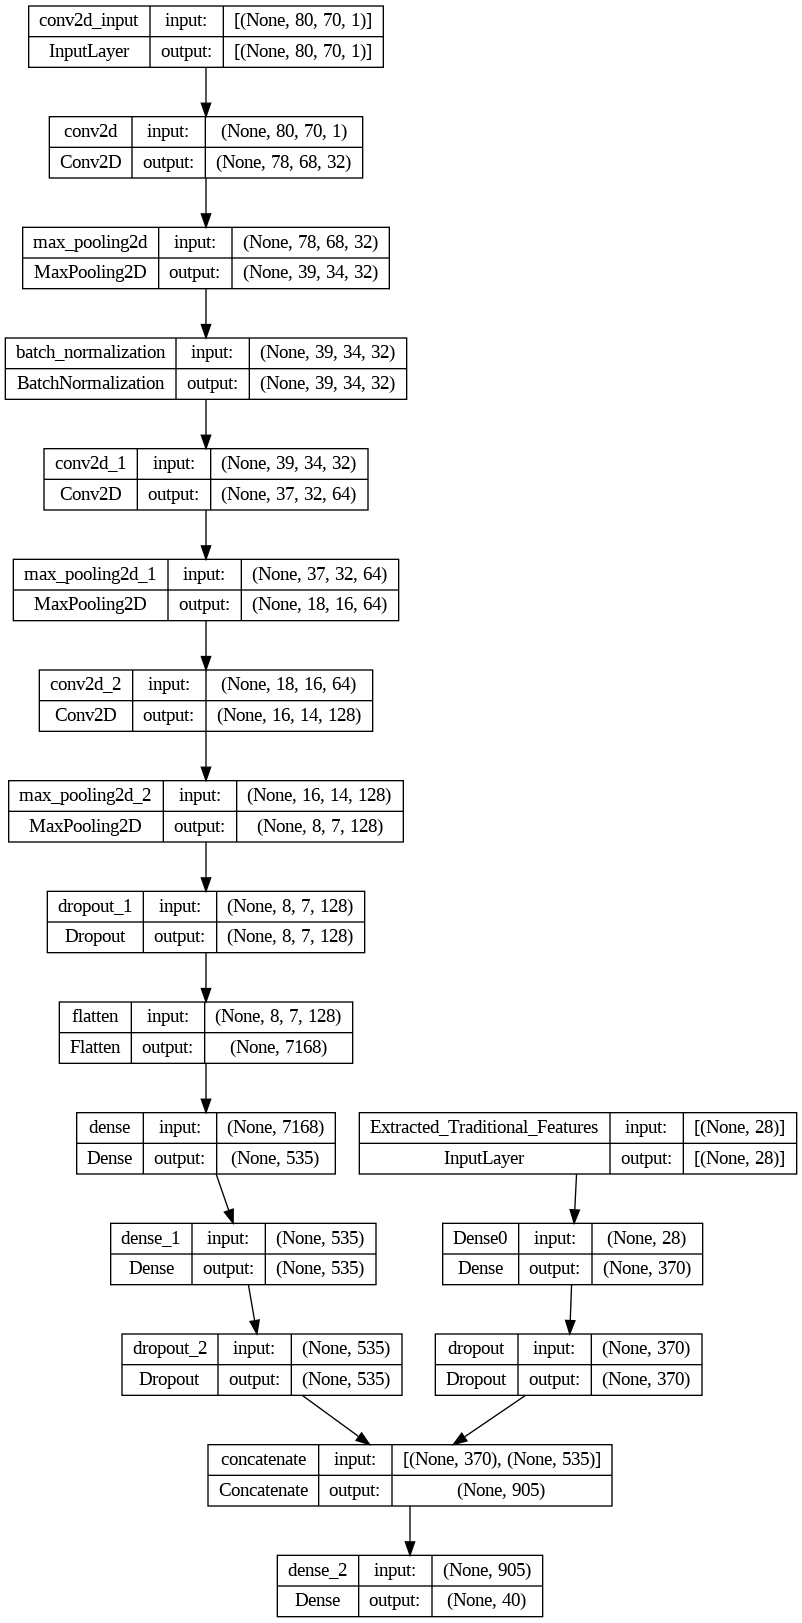

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('dct-weights.{epoch:02d}.h5', save_weights_only=True)


cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
    checkpoint
]

In [19]:
start = time.time()
history = model.fit([X_train, X_train_img], y_train_img, epochs=100, batch_size=16, validation_data=([X_val, X_val_img], y_val_img), callbacks = cb)
finish = time.time()


Epoch 1/100
15/15 [==============================] - 3s 166ms/step - loss: 3.9297 - accuracy: 0.0250 - val_loss: 4.0236 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 2/100
15/15 [==============================] - 2s 146ms/step - loss: 3.6153 - accuracy: 0.0542 - val_loss: 3.6073 - val_accuracy: 0.0750 - lr: 1.0000e-04
Epoch 3/100
15/15 [==============================] - 2s 144ms/step - loss: 3.3812 - accuracy: 0.1167 - val_loss: 3.4473 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 4/100
15/15 [==============================] - 2s 164ms/step - loss: 3.1131 - accuracy: 0.1792 - val_loss: 3.2620 - val_accuracy: 0.1875 - lr: 1.0000e-04
Epoch 5/100
15/15 [==============================] - 3s 195ms/step - loss: 2.8628 - accuracy: 0.2417 - val_loss: 3.1030 - val_accuracy: 0.2250 - lr: 1.0000e-04
Epoch 6/100
15/15 [==============================] - 2s 151ms/step - loss: 2.4875 - accuracy: 0.3875 - val_loss: 2.8412 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 7/100
15/15 [=====================

In [20]:
print('Training time : ', str(finish-start), "second(s)")

Training time :  166.51572918891907 second(s)


In [21]:
start_test = time.time()
test_loss, test_acc = model.evaluate([X_test, X_test_img], y_test_img)
finish_test = time.time()
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Testing time : ', str(finish_test-start_test), "second(s)")

3/3 [==============================] - 0s 52ms/step - loss: 0.1043 - accuracy: 0.9625
Test loss: 0.10434795916080475
Test accuracy: 0.9624999761581421
Testing time :  0.3640456199645996 second(s)


In [22]:
# Extract features from the trained CNN model
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
train_features = feature_extractor.predict([X_train, X_train_img])
test_features = feature_extractor.predict([X_test, X_test_img])


3/3 [==============================] - 0s 70ms/step


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(train_features, np.argmax(y_train, axis=1))
train_features_lda = lda.transform(train_features)
test_features_lda = lda.transform(test_features)

In [24]:
train_features_lda.shape

(240, 39)

In [25]:
classifier = Sequential()
classifier.add(Dense(40, activation='softmax', input_shape=(39,)))  # Number of classes = 10
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(train_features_lda, y_train, batch_size=128, epochs=100, verbose=1)


Epoch 1/100
2/2 [==============================] - 0s 10ms/step - loss: 7.0087 - accuracy: 0.0458
Epoch 2/100
2/2 [==============================] - 0s 10ms/step - loss: 6.8053 - accuracy: 0.0458
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 6.6112 - accuracy: 0.0542
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 6.4181 - accuracy: 0.0667
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 6.2284 - accuracy: 0.0667
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 6.0428 - accuracy: 0.0875
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 5.8621 - accuracy: 0.1250
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 5.6818 - accuracy: 0.1500
Epoch 9/100
2/2 [==============================] - 0s 13ms/step - loss: 5.5068 - accuracy: 0.1667
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 5.3357 - accuracy: 0.1917
Epoch 11/100
2/2 [========

In [26]:
# Evaluate the classifier on test data
predictions = np.argmax(classifier.predict(test_features_lda), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

3/3 [==============================] - 0s 3ms/step
Accuracy: 86.25%
